In [3]:
import scipy
from Gesture import GestureSet

Gestures = scipy.io.loadmat('gesture_dataset.mat')
gestures = Gestures['gestures']
# print(gestures)
# # gesture_sets = [GestureSet(g) for g in gestures[0]]

In [13]:
test = [i for i in range(12)]
print(test)
print(test[2::3])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[2, 5, 8, 11]


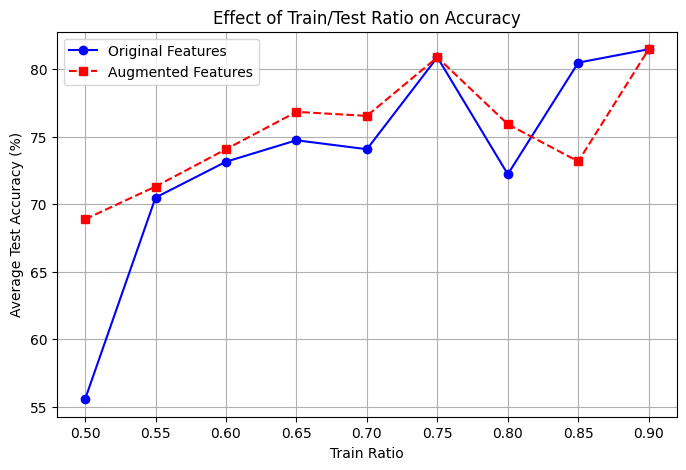

((0.9, 81.48148148148148), (0.9, 81.48148148148148))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from normalize_frames import normalize_frames
from load_gestures import load_gestures
from Gesture import Frame  # Assuming `Frame` now includes `augment_features`

joints = [
    "head",
    "neck",
    "left_shoulder",
    "left_elbow",
    "left_hand",
    "right_shoulder",
    "right_elbow",
    "right_hand",
    "torso",
    "left_hip",
    "right_hip",
]
dims = ["x", "y", "z"]

# Properties
USE_AUGMENT = True
num_frames = 36
train_ratios = np.linspace(0.5, 0.9, 9)  # Testing train ratios from 50% to 90%

# 1. Load & Normalize Data
gesture_sets = load_gestures()
gesture_sets = normalize_frames(gesture_sets, num_frames)

# 2. Extract Features & Labels
samples, labels = [], []

for gs in gesture_sets:
    for seq in gs.sequences:
        sample = np.concatenate([frame.frame for frame in seq.frames])
        samples.append(sample)
        labels.append(int(gs.label))

X_original, Y = np.vstack(samples), np.array(labels)  # Original feature matrix

# 3. Augment Features
if USE_AUGMENT:
    augmented_samples = []
    for gs in gesture_sets:
        for seq in gs.sequences:
            sample = np.concatenate([frame.augment_features() for frame in seq.frames])
            augmented_samples.append(sample)


    X_augmented = np.vstack(augmented_samples)


# Function to test different train/test ratios
def test_different_ratios(X, Y, ratios, num_trials=5):
    """
    Tests different train/test ratios multiple times and finds the best one.

    :param X: Feature matrix (num_samples, num_features)
    :param Y: Labels (num_samples,)
    :param ratios: List of train/test ratios to test.
    :param num_trials: Number of times to repeat each test for stability.
    :return: Dictionary with average test accuracy for each ratio.
    """
    accuracy_results = {}

    for ratio in ratios:
        accuracies = []
        for _ in range(num_trials):
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=ratio, random_state=10)

            # Train Decision Tree Classifier
            clf = DecisionTreeClassifier(criterion="gini", random_state=10)
            clf.fit(X_train, y_train)

            # Test the model
            y_test_pred = clf.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_test_pred) * 100
            accuracies.append(test_accuracy)

        # Store the average accuracy
        accuracy_results[ratio] = np.mean(accuracies)

    return accuracy_results


# Run tests for both original and augmented data
accuracy_results_original = test_different_ratios(X_original, Y, train_ratios)
if USE_AUGMENT:
    accuracy_results_augmented = test_different_ratios(X_augmented, Y, train_ratios) if X_augmented is not None else None

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(train_ratios, list(accuracy_results_original.values()), marker='o', linestyle='-', label="Original Features", color='blue')

if USE_AUGMENT:
    plt.plot(train_ratios, list(accuracy_results_augmented.values()), marker='s', linestyle='--', label="Augmented Features", color='red')

plt.xlabel("Train Ratio")
plt.ylabel("Average Test Accuracy (%)")
plt.title("Effect of Train/Test Ratio on Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Find the best ratio for both cases
best_ratio_original = max(accuracy_results_original, key=accuracy_results_original.get)
best_accuracy_original = accuracy_results_original[best_ratio_original]

if USE_AUGMENT:
    best_ratio_augmented = max(accuracy_results_augmented, key=accuracy_results_augmented.get) if accuracy_results_augmented else None
    best_accuracy_augmented = accuracy_results_augmented[best_ratio_augmented] if accuracy_results_augmented else None

(best_ratio_original, best_accuracy_original), (best_ratio_augmented, best_accuracy_augmented)


Training Unidirectional LSTM (B=8, L=8, E=40)...
Training Bidirectional LSTM (B=8, L=8, E=40)...
Training Unidirectional LSTM (B=8, L=8, E=100)...
Training Bidirectional LSTM (B=8, L=8, E=100)...
Training Unidirectional LSTM (B=8, L=8, E=200)...
Training Bidirectional LSTM (B=8, L=8, E=200)...
Training Unidirectional LSTM (B=8, L=12, E=40)...
Training Bidirectional LSTM (B=8, L=12, E=40)...
Training Unidirectional LSTM (B=8, L=12, E=100)...
Training Bidirectional LSTM (B=8, L=12, E=100)...
Training Unidirectional LSTM (B=8, L=12, E=200)...
Training Bidirectional LSTM (B=8, L=12, E=200)...
Training Unidirectional LSTM (B=8, L=16, E=40)...
Training Bidirectional LSTM (B=8, L=16, E=40)...
Training Unidirectional LSTM (B=8, L=16, E=100)...
Training Bidirectional LSTM (B=8, L=16, E=100)...
Training Unidirectional LSTM (B=8, L=16, E=200)...
Training Bidirectional LSTM (B=8, L=16, E=200)...
Training Unidirectional LSTM (B=12, L=8, E=40)...
Training Bidirectional LSTM (B=12, L=8, E=40)...
Trai

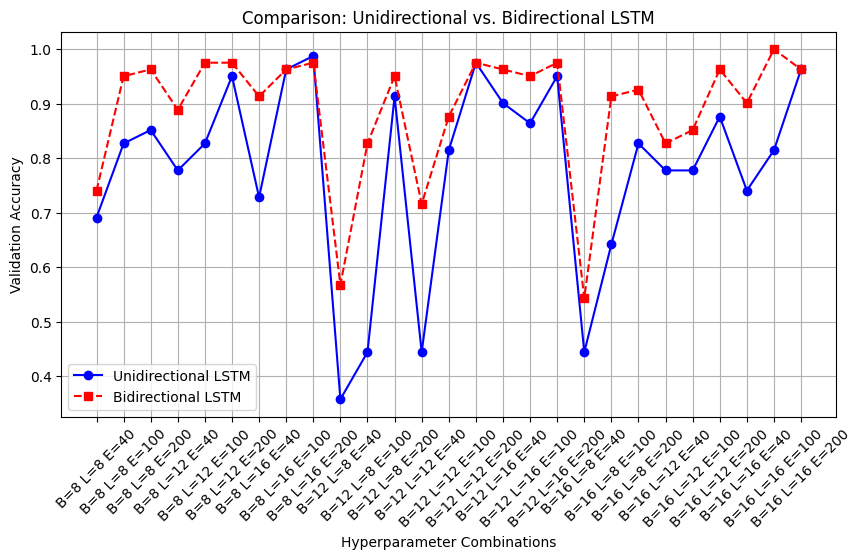

In [6]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Bidirectional
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from normalize_frames import normalize_frames
from load_gestures import load_gestures

# Fix random seed for reproducibility
np.random.seed(80)

# Load and format gesture data
gesture_sets = load_gestures()
gesture_sets = normalize_frames(gesture_sets, 36)

# Extract samples and labels
samples, labels = [], []
for gs in gesture_sets:
    for seq in gs.sequences:
        sample = np.vstack([x.frame for x in seq.frames])
        samples.append(sample)
        labels.append(gs.label)

X = np.array(samples)  # Shape: (num_samples, time_steps, num_features)
Y = np.array(labels)   # Shape: (num_samples,)

# Split into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

# Reduce hyperparameter search space (3x3x3 grid search)
batch_sizes = [8, 12, 16]  # Reduced batch sizes
latent_dims = [8, 12, 16]   # Reduced latent dims
epochs_list = [40, 100, 200]  # Reduced epoch list

# Store results for both models
results_single = []
results_bidirectional = []
best_single = {"val_acc": 0.0}
best_bidirectional = {"val_acc": 0.0}

# Function to build and train LSTM model
def train_lstm(batch_size, latent_dim, epochs, use_bidirectional=False):
    input_layer = Input(shape=(X.shape[1:]))

    if use_bidirectional:
        lstm = Bidirectional(LSTM(latent_dim))(input_layer)
    else:
        lstm = LSTM(latent_dim)(input_layer)

    dense = Dense(latent_dim, activation="relu")(lstm)
    pred = Dense(len(np.unique(Y)), activation="softmax")(dense)

    model = Model(inputs=input_layer, outputs=pred)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["acc"])

    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        verbose=0,  # Set to 1 for detailed output
        shuffle=True
    )

    # Get final validation accuracy
    val_acc = max(history.history['val_acc'])

    return val_acc, history.history

# Perform hyperparameter tuning for both models
for batch_size, latent_dim, epochs in itertools.product(batch_sizes, latent_dims, epochs_list):
    print(f"Training Unidirectional LSTM (B={batch_size}, L={latent_dim}, E={epochs})...")
    val_acc_single, history_single = train_lstm(batch_size, latent_dim, epochs, use_bidirectional=False)

    print(f"Training Bidirectional LSTM (B={batch_size}, L={latent_dim}, E={epochs})...")
    val_acc_bi, history_bi = train_lstm(batch_size, latent_dim, epochs, use_bidirectional=True)

    # Store results
    results_single.append({"batch_size": batch_size, "latent_dim": latent_dim, "epochs": epochs, "val_acc": val_acc_single})
    results_bidirectional.append({"batch_size": batch_size, "latent_dim": latent_dim, "epochs": epochs, "val_acc": val_acc_bi})

    # Update best results
    if val_acc_single > best_single["val_acc"]:
        best_single = {"batch_size": batch_size, "latent_dim": latent_dim, "epochs": epochs, "val_acc": val_acc_single}

    if val_acc_bi > best_bidirectional["val_acc"]:
        best_bidirectional = {"batch_size": batch_size, "latent_dim": latent_dim, "epochs": epochs, "val_acc": val_acc_bi}

# Print best results
print("\nBest Unidirectional LSTM:", best_single)
print("Best Bidirectional LSTM:", best_bidirectional)

# Plot results
plt.figure(figsize=(10, 5))
x_values = range(len(results_single))
plt.plot(x_values, [r["val_acc"] for r in results_single], marker='o', linestyle='-', color='b', label="Unidirectional LSTM")
plt.plot(x_values, [r["val_acc"] for r in results_bidirectional], marker='s', linestyle='--', color='r', label="Bidirectional LSTM")

plt.xticks(x_values, [f"B={r['batch_size']} L={r['latent_dim']} E={r['epochs']}" for r in results_single], rotation=45)
plt.xlabel("Hyperparameter Combinations")
plt.ylabel("Validation Accuracy")
plt.title("Comparison: Unidirectional vs. Bidirectional LSTM")
plt.legend()
plt.grid()
plt.show()



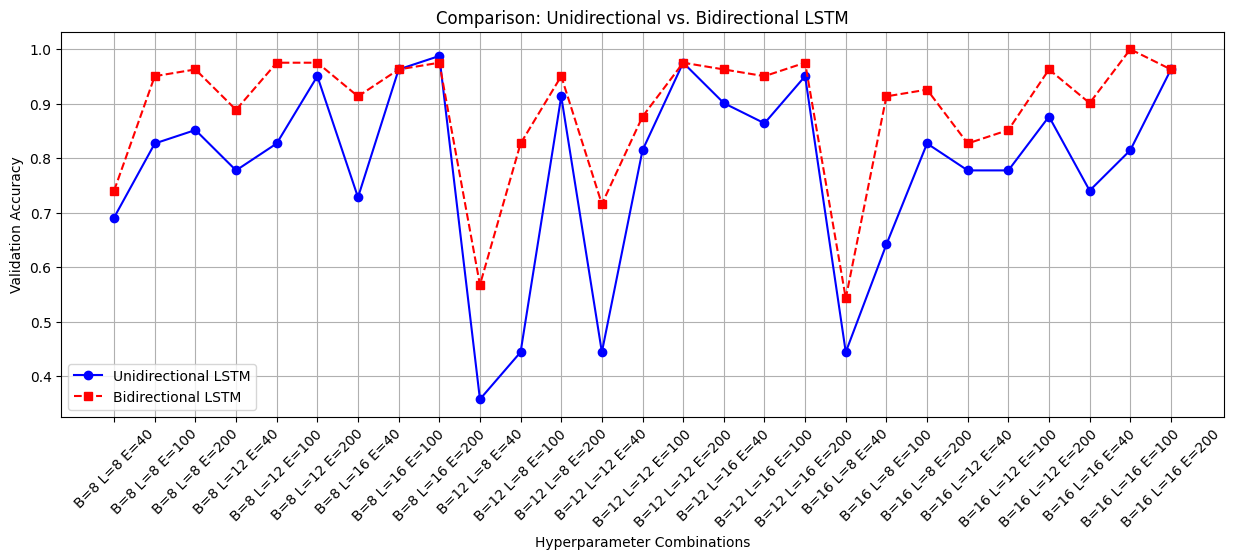

In [9]:
# Plot results
plt.figure(figsize=(15, 5))
x_values = range(len(results_single))
plt.plot(x_values, [r["val_acc"] for r in results_single], marker='o', linestyle='-', color='b', label="Unidirectional LSTM")
plt.plot(x_values, [r["val_acc"] for r in results_bidirectional], marker='s', linestyle='--', color='r', label="Bidirectional LSTM")

plt.xticks(x_values, [f"B={r['batch_size']} L={r['latent_dim']} E={r['epochs']}" for r in results_single], rotation=45)
plt.xlabel("Hyperparameter Combinations")
plt.ylabel("Validation Accuracy")
plt.title("Comparison: Unidirectional vs. Bidirectional LSTM")
plt.legend()
plt.grid()
plt.show()

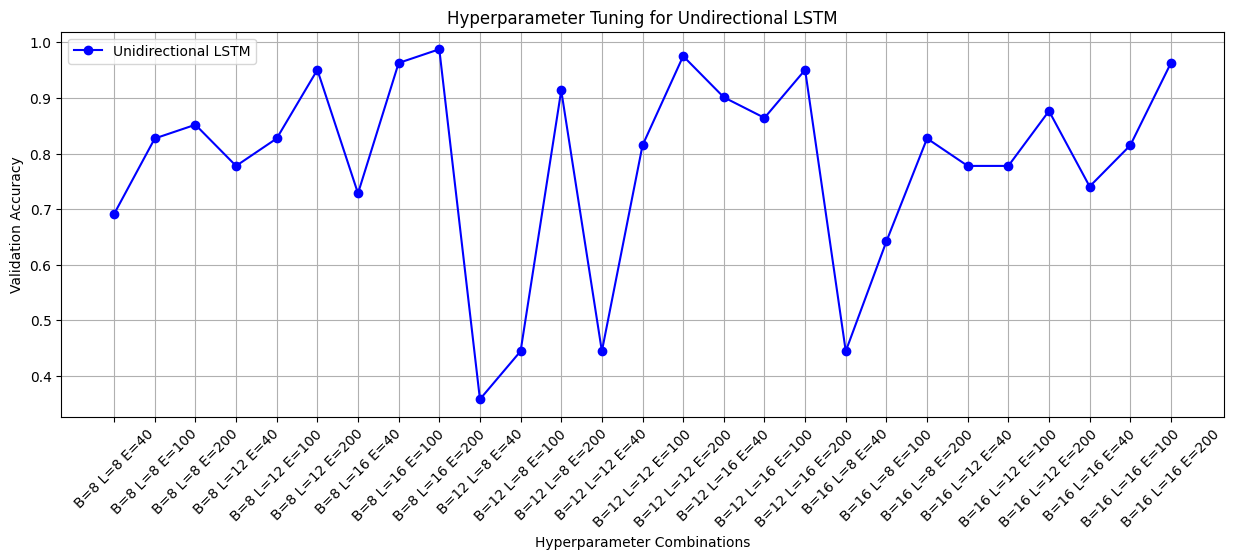

In [8]:
# Plot results
plt.figure(figsize=(15, 5))
x_values = range(len(results_single))
plt.plot(x_values, [r["val_acc"] for r in results_single], marker='o', linestyle='-', color='b', label="Unidirectional LSTM")
# plt.plot(x_values, [r["val_acc"] for r in results_bidirectional], marker='s', linestyle='--', color='r', label="Bidirectional LSTM")

plt.xticks(x_values, [f"B={r['batch_size']} L={r['latent_dim']} E={r['epochs']}" for r in results_single], rotation=45)
plt.xlabel("Hyperparameter Combinations")
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter Tuning for Undirectional LSTM")
plt.legend()
plt.grid()
plt.show()

# Question 1

Looking at sequences of the same gesture type, there are observable variations in the way people perform gestures.
- **Extra body movement**: For example, in the zoom-in (two hands moving outward) gesture, some sequences show pure hand movement, while others include head or shoulder movement/rotation. 
- **Speed differences**: Some gestures move quickly while others are slower
- **Trajectory variation**: Hands move in slightly different paths for same gesture type, which can be observed in Point category.

If poses are not normalized, there will be below challenges:
- **Varied body size**: If participants have different body sizes, the raw positions of joints would be inconsistent.A model trained on one person's data might fail when tested on another person with different proportions.
- **Orientation**: If people face slightly different directions while performing gestures, their hand positions relative to the body would shift. These misaligned poses would not match correctly with gestures performed facing directly forward.


## Question 2

The chance performance will depend on the prior probability distribution of the labels in the training set. Given there are 9 gesture labels, and the gestures are uniformly distributed across these labels , the random guessing will have accuracy of **1/9**

## Question 3

The Nearest Neighbor (NN) algorithm relies on directly comparing sequences using a distance metric. In our case, L2 norm is used, which computes the rooted average of point-wise squared distance.
$$
d(A,B) = \sqrt{\sum_{i=1}^{N}(A_i - B_i)^2}
$$

If A has 20 frames and another has 10, you can't directly compute the difference.

## Question4

**Pros**
- There is no training required, we only store training data and compute L2 distances. This method will work well with small dataset, without requiring huge amounts of training data.
- This is non-parametric method. Unlike the models such as Neural Nets that require parametric assumption on data distributions. Nearest neighbor can handle complex, non-linear gesture patterns.

**Cons**
- It is computationally expensive. As each inference will required O(N) to compare with all training data.
- It requires fixed-length sequence. Unlike neural networks like RNN can allow flexible length, NN due to pointwise L2 distance metric, requiring resampling when preprocssing the data.
- It is sensitive to outliers. If the gesture sequences have many unnecessary motion, it will heavily influence NN's performance. 

# Question 5

Accuracy at ```num_frames = 20``` and ```ratio = 0.4``` is **0.75926**

The code and visualization of parameter grid search is attached below. The best parameter tried sofar is ```num_frames = 25``` and ```ratio = 0.4``` which yields an accuracy of **0.8519**



Tested num_frames=10, ratio=0.3, Accuracy=0.6561
Tested num_frames=10, ratio=0.4, Accuracy=0.7099
Tested num_frames=10, ratio=0.5, Accuracy=0.7259
Tested num_frames=10, ratio=0.6, Accuracy=0.7407
Tested num_frames=10, ratio=0.7, Accuracy=0.7901
Tested num_frames=15, ratio=0.3, Accuracy=0.6243
Tested num_frames=15, ratio=0.4, Accuracy=0.7531
Tested num_frames=15, ratio=0.5, Accuracy=0.6593
Tested num_frames=15, ratio=0.6, Accuracy=0.7500
Tested num_frames=15, ratio=0.7, Accuracy=0.7407
Tested num_frames=20, ratio=0.3, Accuracy=0.7249
Tested num_frames=20, ratio=0.4, Accuracy=0.7593
Tested num_frames=20, ratio=0.5, Accuracy=0.7778
Tested num_frames=20, ratio=0.6, Accuracy=0.7315
Tested num_frames=20, ratio=0.7, Accuracy=0.7901
Tested num_frames=25, ratio=0.3, Accuracy=0.6931
Tested num_frames=25, ratio=0.4, Accuracy=0.7037
Tested num_frames=25, ratio=0.5, Accuracy=0.7852
Tested num_frames=25, ratio=0.6, Accuracy=0.7315
Tested num_frames=25, ratio=0.7, Accuracy=0.8519
Tested num_frames=30

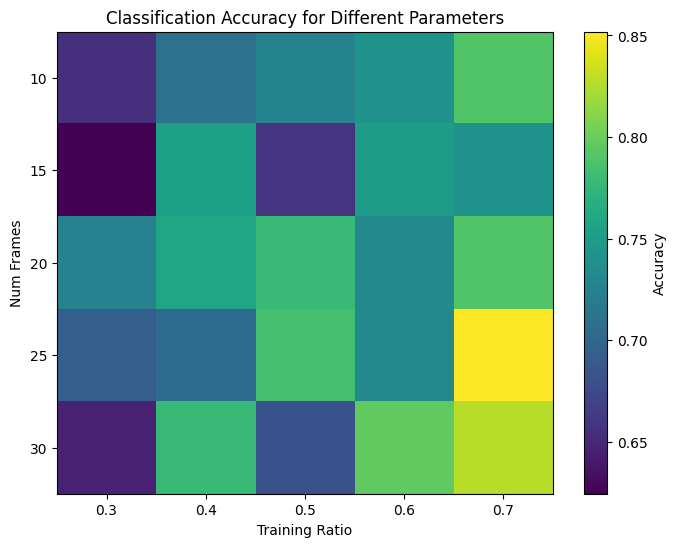

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from test_classify_nn import test_classify_nn
frame_options=[10,15, 20, 25,30]
ratio_options=[0.3, 0.4, 0.5, 0.6,0.7]

accuracy_results = np.zeros((len(frame_options), len(ratio_options)))

# Run tests for each combination of num_frames and ratio
for i, num_frames in enumerate(frame_options):
    for j, ratio in enumerate(ratio_options):
        accuracy = test_classify_nn(num_frames, ratio)
        accuracy_results[i, j] = accuracy
        print(f"Tested num_frames={num_frames}, ratio={ratio}, Accuracy={accuracy:.4f}")

# Visualize the results using a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(accuracy_results, cmap="viridis", aspect="auto", interpolation="nearest")
plt.colorbar(label="Accuracy")
plt.xticks(ticks=np.arange(len(ratio_options)), labels=[f"{r}" for r in ratio_options])
plt.yticks(ticks=np.arange(len(frame_options)), labels=[f"{f}" for f in frame_options])
plt.xlabel("Training Ratio")
plt.ylabel("Num Frames")
plt.title("Classification Accuracy for Different Parameters")
plt.show()



# Question 6

The variety of test accuracy comes from the inherent randomness in Scikit-learn's ```DecisionTreeClassifier```. For instance, the features are randomly permuted at each split, which will influence the selection of the best feature.Additionally,When the number of features to consider ```(max_features)``` is less than the total number of features ```(n_features)```, the algorithm randomly selects a subset of features at each split before determining the best split among them. 

The easiest fix is to setting the ```random_state``` input in the scipy's decision tree classifier.

# Question 7

- **Input Features (X):** Flattened gesture sequences with (x, y, z) coordinates of **11 joints** over **36 frames**.
  - **Shape:** `(270, 1188)` → **270 samples**, each with **1188 features** (`36 frames × 33 coordinates`).
  
- **Labels (Y):** Integer class labels for each gesture.
  - **Shape:** `(270,)` → 270 labels corresponding to gestures.

- **Train/Test Split:**
  - **Training Set:** `X_train (189, 1188)`, `y_train (189,)` (**70% data**).
  - **Testing Set:** `X_test (81, 1188)`, `y_test (81,)` (**30% data**).

- **Decision Tree Model:**
  - **Total Features Used:** `1188`
  - **Training Accuracy:** `100.0%`
  - **Testing Accuracy:** `74.07%` (suggests potential overfitting).




**Test of Split Ratio Parameters**

For each ratio, I repeated 5 times for stability of test accuracy

**Best Ratio** is **0.9** with **81.481** accuracy
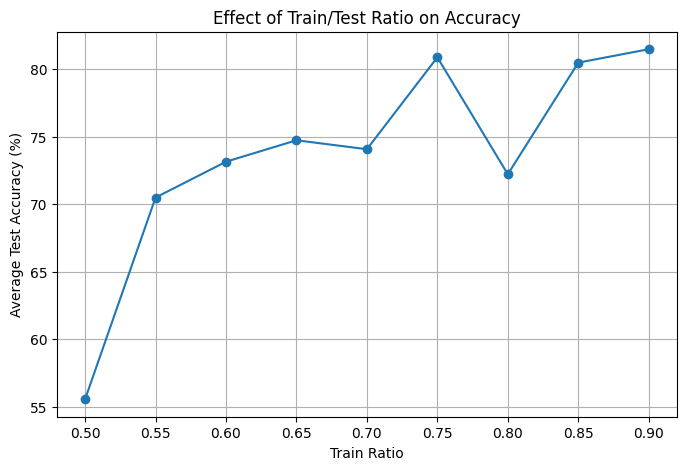

# Question 8

Gini impurity measures how often a randomly chosen sample would be **incorrectly classified** if it were randomly labeled according to the class distribution.
According to the equations:
$$
Gini(S) = 1 - \sum_{i=1}^{c} p_i^2
$$
where $S$ is the dataset, $c$ is number of clases and $p_i$ is the proportion of samples belong to class $i$

In the equation, the probability of a randomly picked sample belonging to class $i$ is $p_i$, the probability of picking a class $i$ is also $p_i$, therefore, the probability of a correct guess of a randomly drawn sample is $\sum_{i=1}^{c}p_i^2$. And thus incorrect guess probability will be $1-\sum_{i=1}^{c}p_i^2$. In the binary case where $c=2$, if the classifier can predict one label as probability of 1, then the Gini loss will be 0, which measures the impurity.

In the splitting tree, the Gini can be written as 
$$
Gini(S|X) = \sum_{j=1}^{n} \frac{|S_j|}{|S|} Gini(S_j)
$$
If Gini impurity decreases after the split, the feature is a good candidate for splitting.

# Question 9

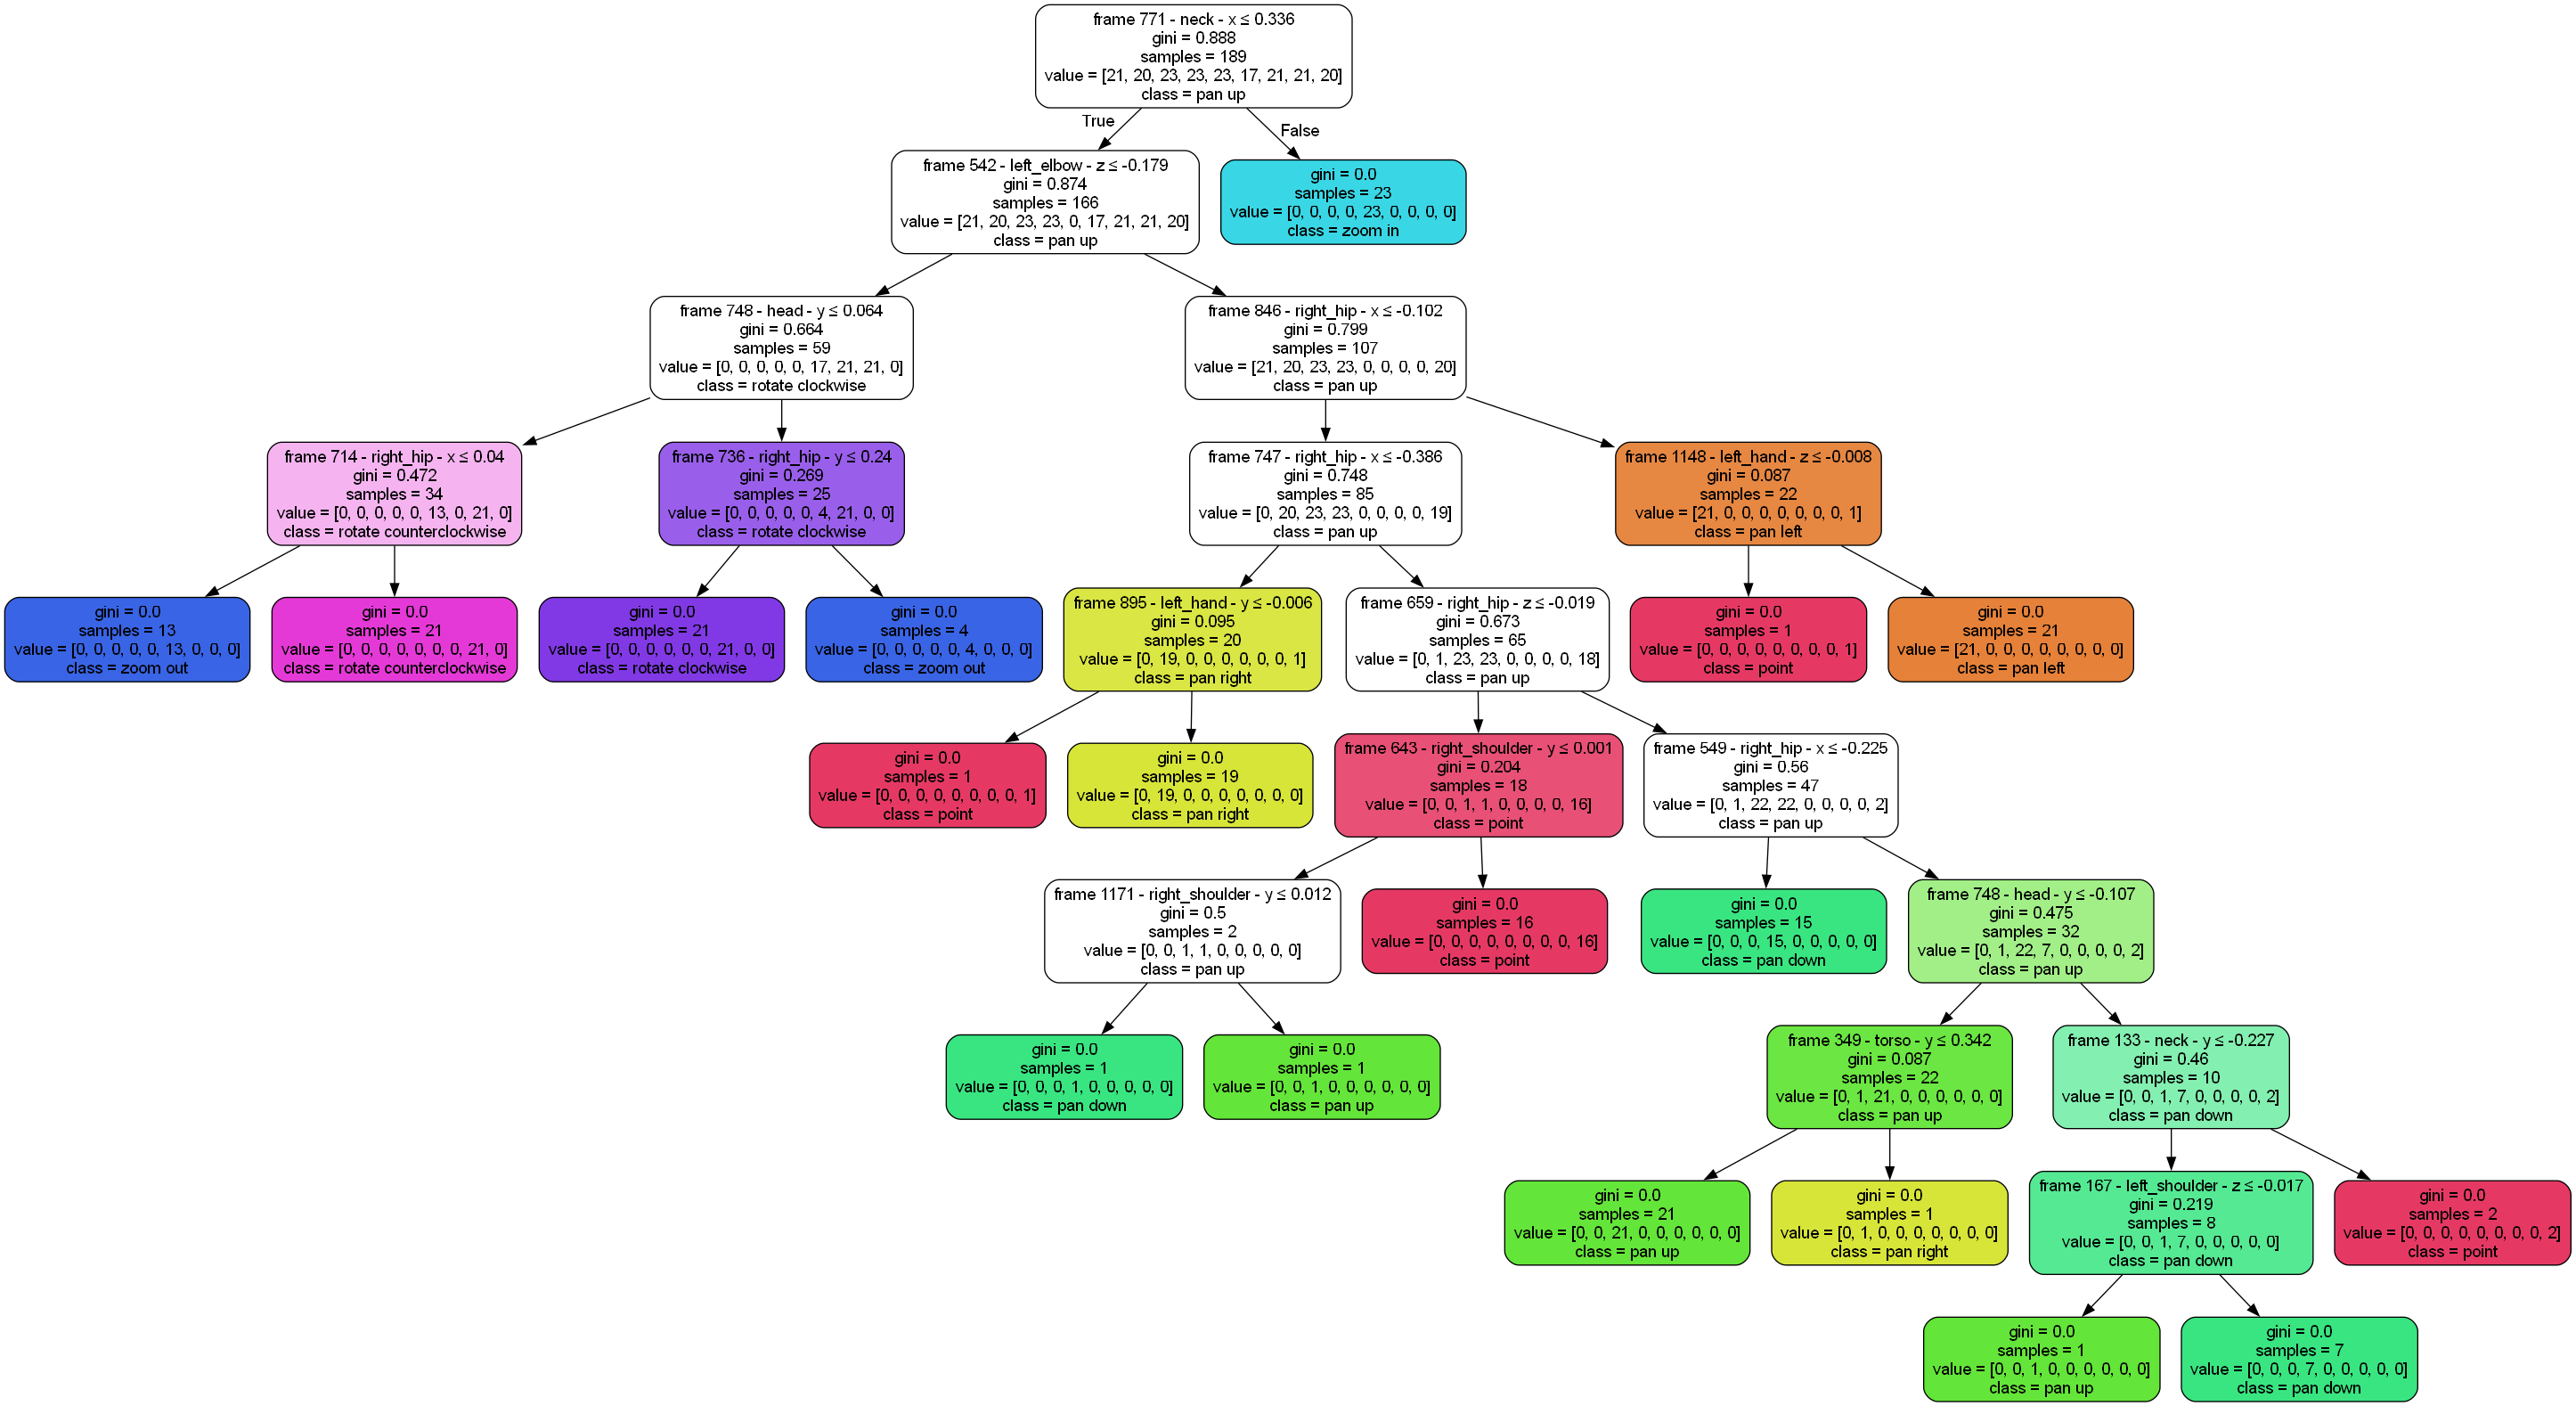

The training accuracy is **100.0%**. 
- gini: Represents the Gini impurity of the node as discussed in last question
- samples: the sample size ( number of data points) that reached this node
- value: a list of label size representing the number of samples belong to each label. ```value[label] == num_sample_label```
- class: predicted class for that node, which is determined by the majority class in value.
- leaf node with ```gini = 0```:Every leaf contains samples from only one class.If all samples at a node belong to a single class , the gini will be:
$$
Gini = 1 - (1^2 +0^2 + 0^2 + ...) = 0
$$


# Extra Credit 1

I add some helper methods inide ```Frame``` class:
- Velocity (```compute_joint_velocity```):Computes joint-wise velocities using ```v = (x_current - x_previous) / delta_t.```
- Joint Angles (```compute_joint_angles```): Uses cosine similarity to compute angles between adjacent joints.Returns angles in degrees.
- Angular Velocity(```compute_angular_velocity```): Computes the rate of change of joint angles.
- Feature Augmentation (```augment_features```):Calls all three feature functions.Appends them to ```self.frame```.

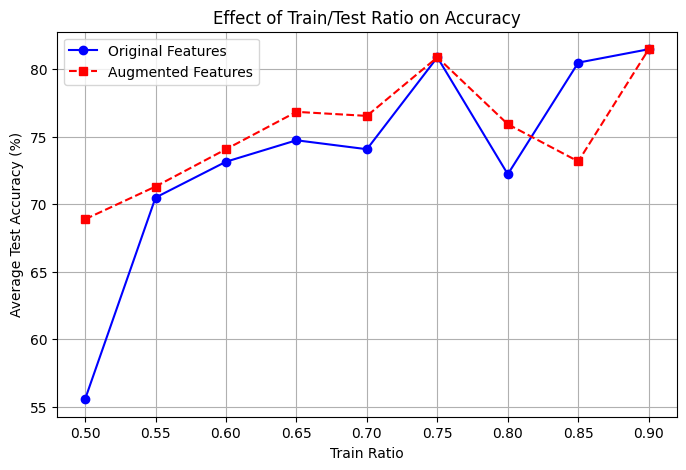

**Improvements** :The augmented feature set consistently outperforms the original feature set across most train/test ratios (except for 0.85).Besides,The augmented feature accuracy curve is smoother, meaning the model performs more consistently across different training sizes.The original feature curve fluctuates more, indicating higher sensitivity to training data size.At lower train ratios (0.50 - 0.75), augmentation provides a significant boost (up to +5% accuracy).This is important when training data is limited, as **the model is able to learn better from fewer samples**.


# Question 10

The gesture data is formated in shape of ```(num_samples,num_frame,feature_dim)```
and shuffled before passing to LSTM model. The LSTM model expects data in  ```(batch_size, time_steps, num_features)``` format. Each gesture sequence is treated as a time-series input, where each frame will be processed into hidden variables and passed to next step.

I performed grid search in below combination of hyperparameters:
```
batch_sizes = [8, 12, 16, 24]
latent_dims = [8, 12, 16, 24]
epochs_list = [40, 100, 200, 400]
```
Best Hyperparameters: ```{'batch_size': 8, 'latent_dim': 16, 'epochs': 200}``` with validation accuracy as 98.77%, compared to default parameter's accuracy of 95.41%

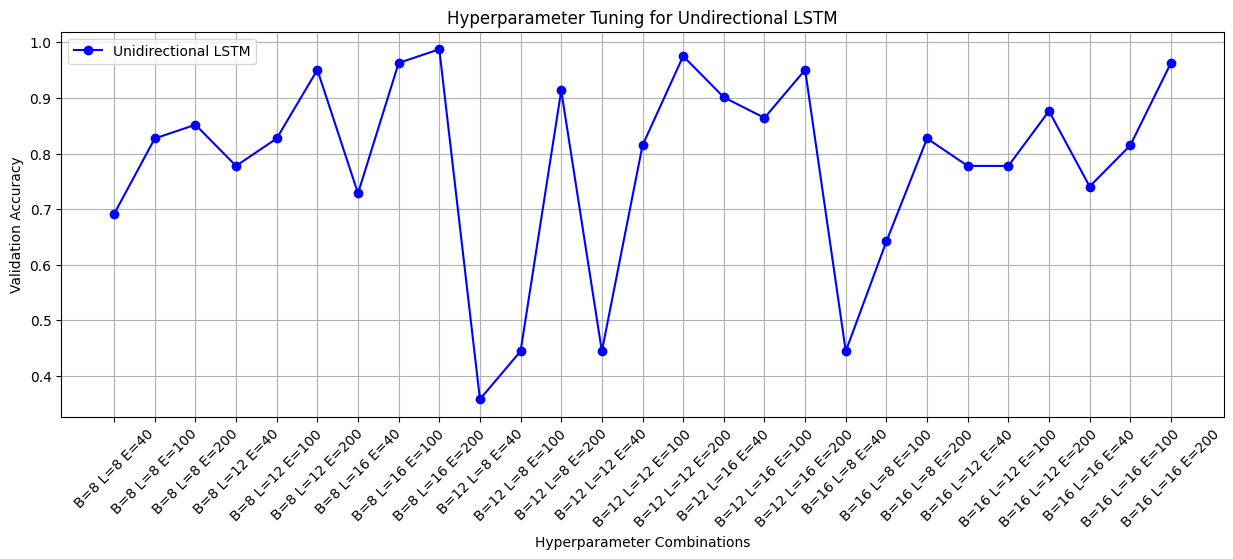

# Question 11


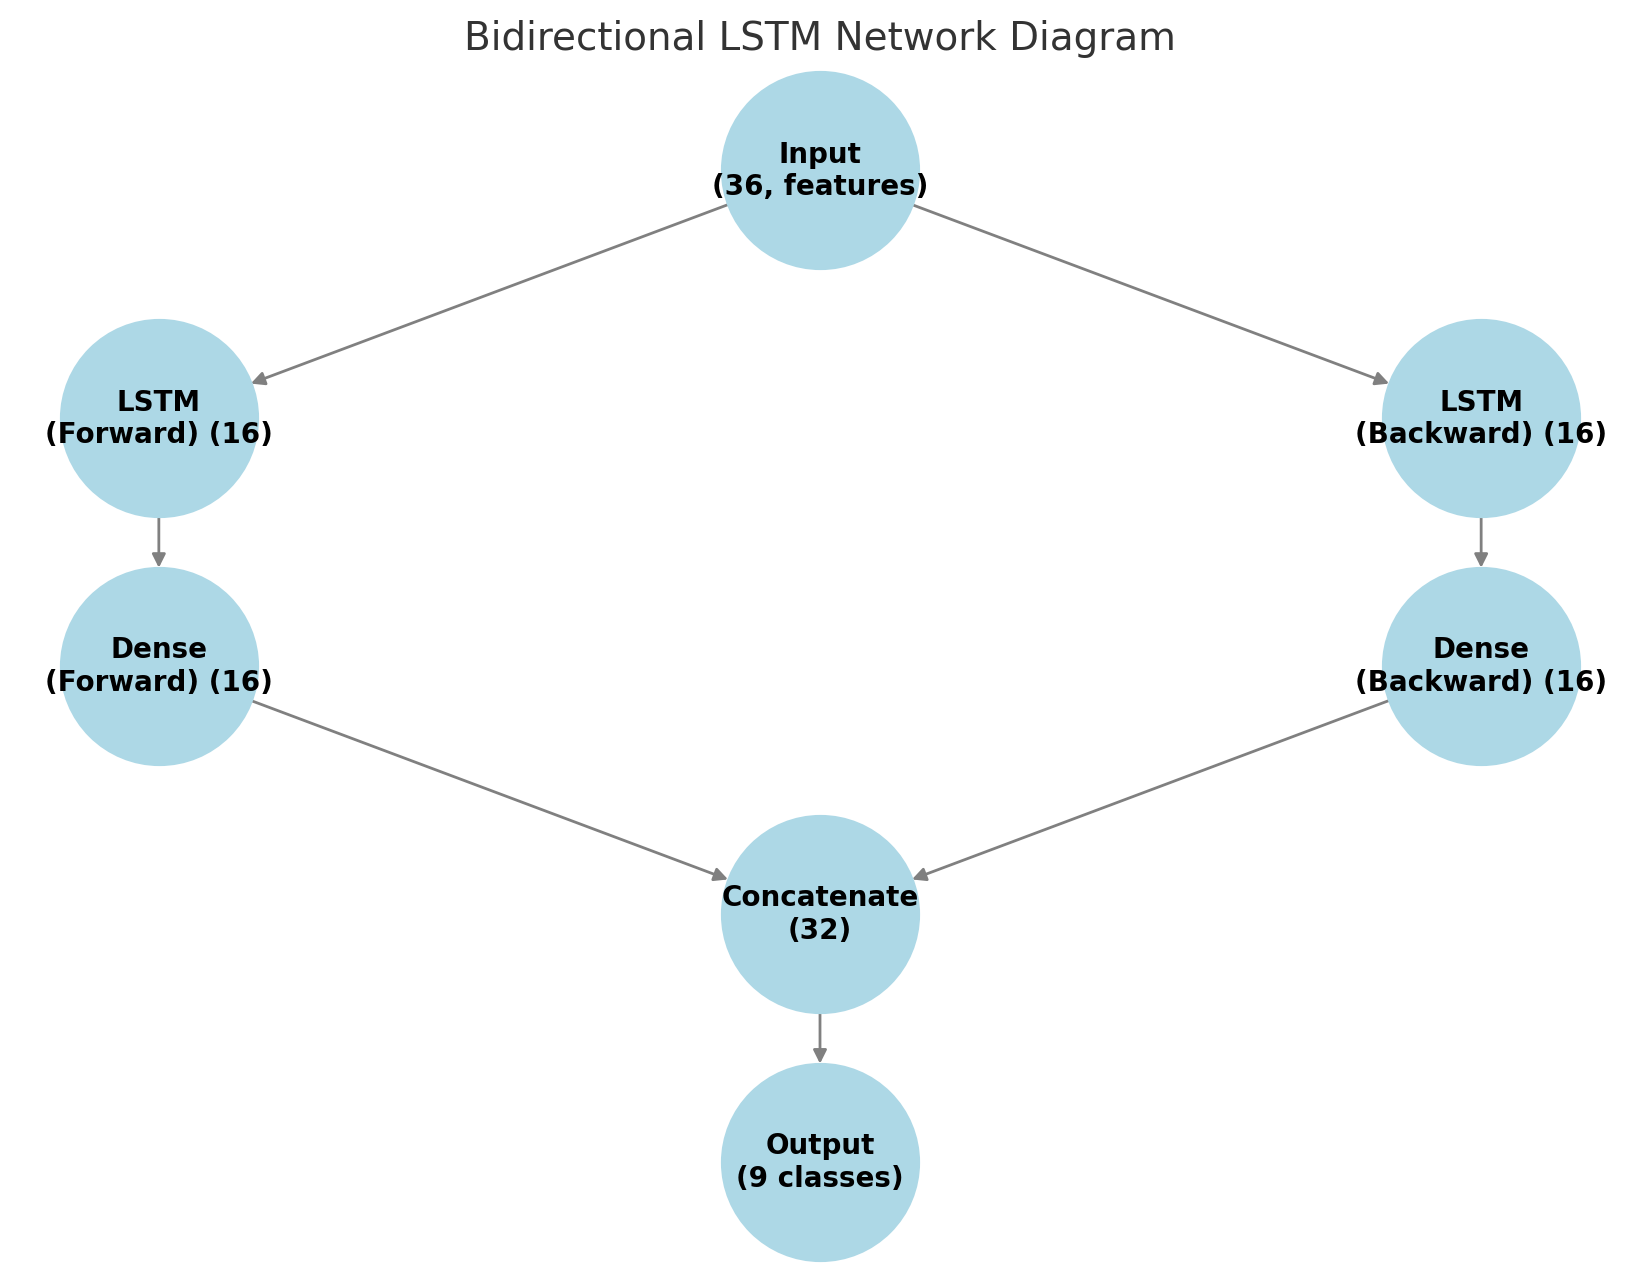

The comparison of perfromance between undirectional and bidirectional LSTM is shown in following plot. Overall,Bidirectional LSTM outperforms Unidirectional LSTM on validation accuracy.

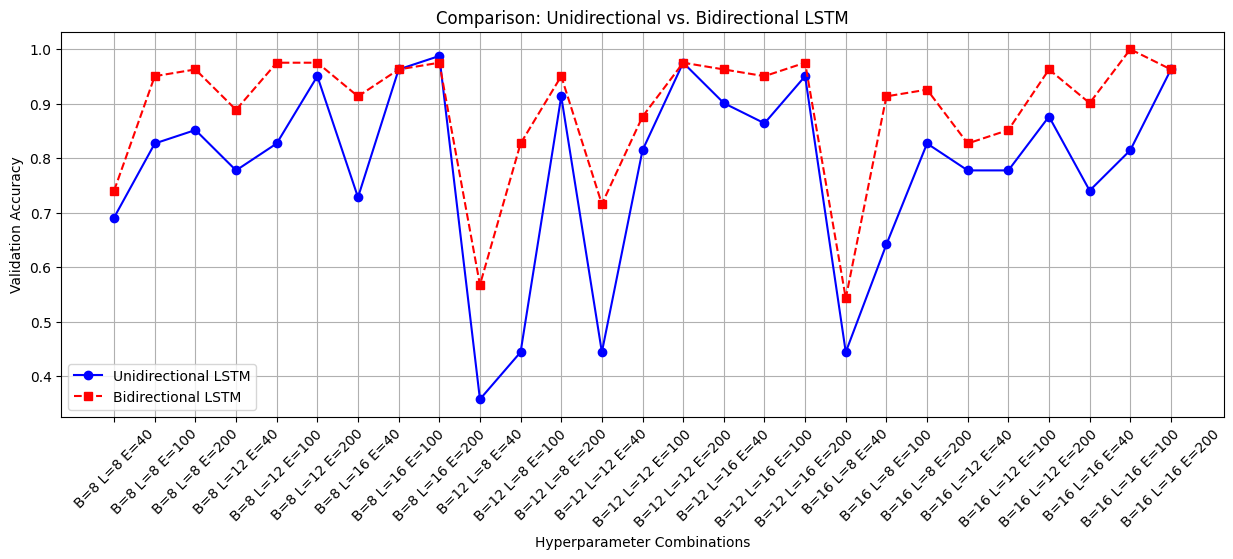

# Extra Credit2